In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
#read the reviews
import pandas as pd
gdrive_path = '/content/drive/MyDrive/mydata/'
data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv")

data.sample(n=10)

,Unnamed: 0,review,sentiment,label
48750,48750,I saw the film tonight at a free preview scree...,negative,0
49253,49253,My wife and I saw this when we were 17. The on...,positive,1
18466,18466,... You can't exactly shove her out of the way...,negative,0
5473,5473,I have read many comments on this site critici...,positive,1
24233,24233,Now here is a movie that does something that h...,positive,1
45763,45763,"I am a lover of B movies, give me a geneticall...",negative,0
44916,44916,"This is definitely Nolan's most intimite,and t...",positive,1
17434,17434,I tuned in to this movie because there was not...,positive,1
640,640,The cast of this film contain some of New Zeal...,negative,0
25399,25399,Obviously made on the cheap to capitalize on t...,positive,1


In [3]:
data.groupby('sentiment').describe()

Unnamed: 0                                                    \
               count         mean           std  min      25%      50%   
sentiment                                                                
negative     25000.0  24964.07768  14461.920812  3.0  12403.5  24940.0   
positive     25000.0  25034.92232  14406.028970  0.0  12577.0  25039.0   

                                label                                     
                75%      max    count mean  std  min  25%  50%  75%  max  
sentiment                                                                 
negative   37482.50  49999.0  25000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
positive   37524.25  49995.0  25000.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [4]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle
import itertools

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
%%time
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 31.2 s, sys: 85.4 ms, total: 31.3 s
Wall time: 37.9 s


In [9]:
data.sample(n=10)

,Unnamed: 0,review,sentiment,label
5445,5445,hate throw lines like case feel like american ...,negative,0
49376,49376,saw film premier week 1975 13 years old time f...,negative,0
45366,45366,quite possibly worst movie ever seen ready wal...,negative,0
46551,46551,checked video expecting like wanting like like...,negative,0
210,210,given 10 thieves highway mention two reasons o...,negative,0
15833,15833,dick tracy black white pope religious giving n...,positive,1
20864,20864,first saw masterpiece vhs 10 years ago powerfu...,positive,1
24962,24962,story held special place heart last thirty one...,positive,1
49571,49571,lets make movie talk show already exists basic...,negative,0
40617,40617,movie honestly one greatest movies time suffer...,negative,0


In [10]:
# split data into train and test set
from sklearn.model_selection import train_test_split

X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
%%time
documents = [_text.split() for _text in data.review]

CPU times: user 665 ms, sys: 172 ms, total: 836 ms
Wall time: 838 ms


In [12]:
print(len(documents))

50000


In [13]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "Sentiment_bilstm_w2vCBOW.sav"
WORD2VEC_MODEL = "modelCBOW.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizerCBOW.pkl"
ENCODER_MODEL = "encoderCBOW.pkl"


In [15]:
# train a CBOW model
w2vmodel_cbow = gensim.models.Word2Vec(documents, vector_size = W2V_SIZE, window = W2V_WINDOW, min_count = W2V_MIN_COUNT, workers = 8, sg = 0)

In [16]:
cbow_words = w2vmodel_cbow.wv.index_to_key
cbow_vocab_size_wv = len(cbow_words)
print("Vocabulary size for CBOW:", cbow_vocab_size_wv)

Vocabulary size for CBOW: 28058


In [17]:
w2vmodel_cbow.wv.most_similar("movie")

[('film', 0.6716843843460083),
 ('movies', 0.6112170219421387),
 ('flick', 0.6015034317970276),
 ('honestly', 0.5136817693710327),
 ('sure', 0.4921829402446747),
 ('suck', 0.4889677166938782),
 ('really', 0.4841112792491913),
 ('disappointed', 0.48341256380081177),
 ('thats', 0.4817763566970825),
 ('guess', 0.4773172438144684)]

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)

CPU times: user 4.66 s, sys: 126 ms, total: 4.78 s
Wall time: 4.7 s


In [19]:
# Checking total number of words

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 3.26 s, sys: 121 ms, total: 3.38 s
Wall time: 3.35 s


In [21]:
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist())
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [24]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [25]:
cbow_embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
     if word in w2vmodel_cbow.wv:
            cbow_embedding_matrix[i] = w2vmodel_cbow.wv[word]
print(cbow_embedding_matrix.shape)

(100947, 300)


In [26]:
cbow_embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[cbow_embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [27]:
cbow_model = Sequential()
cbow_model.add(cbow_embedding_layer)
cbow_model.add(Dropout(0.5))
cbow_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
cbow_model.add(Dense(1, activation='sigmoid'))

cbow_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 30605101 (116.75 MB)
Trainable params: 321001 (1.22 MB)
Non-trainable params: 30284100 (115.52 MB)
_________________________________________________________________


In [28]:
cbow_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
%%time
history = cbow_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

import pickle

cbow_model.save(KERAS_MODEL)
w2vmodel_cbow.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)




Epoch 1/32
36/36 [==============================] - 124s 3s/step - loss: 0.5233 - accuracy: 0.7373 - val_loss: 0.4912 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 2/32
36/36 [==============================] - 99s 3s/step - loss: 0.3894 - accuracy: 0.8331 - val_loss: 0.3684 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 3/32
36/36 [==============================] - 98s 3s/step - loss: 0.3472 - accuracy: 0.8556 - val_loss: 0.3534 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/32
36/36 [==============================] - 98s 3s/step - loss: 0.3208 - accuracy: 0.8654 - val_loss: 0.3408 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 5/32
36/36 [==============================] - 102s 3s/step - loss: 0.3028 - accuracy: 0.8725 - val_loss: 0.3663 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 6/32
36/36 [==============================] - 98s 3s/step - loss: 0.2947 - accuracy: 0.8756 - val_loss: 0.2807 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 7/32
36/36 [==============================] - 98s 3s/step - loss: 0.2821 -

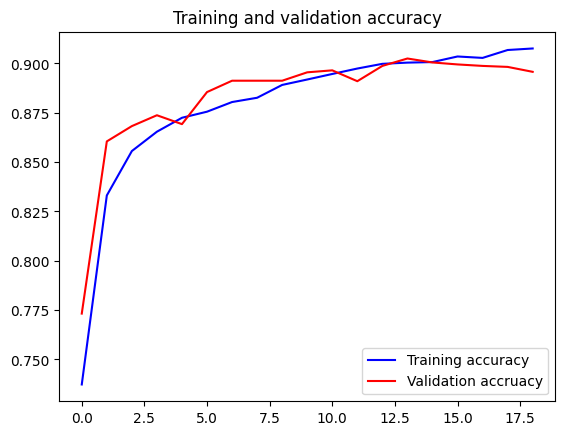

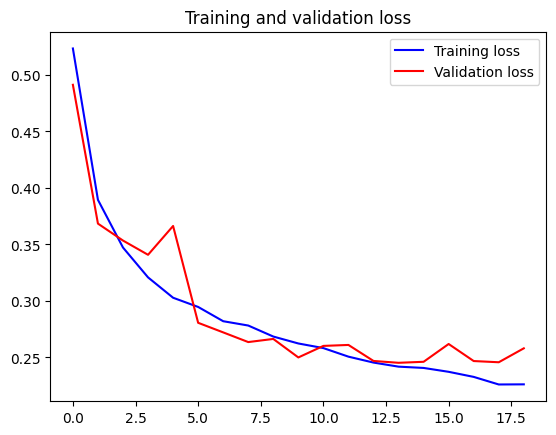

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accruacy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
%%time
score = cbow_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 3s 283ms/step - loss: 0.2518 - accuracy: 0.8995

ACCURACY: 0.8995000123977661
LOSS: 0.25182032585144043
CPU times: user 2.44 s, sys: 49.7 ms, total: 2.49 s
Wall time: 5.22 s


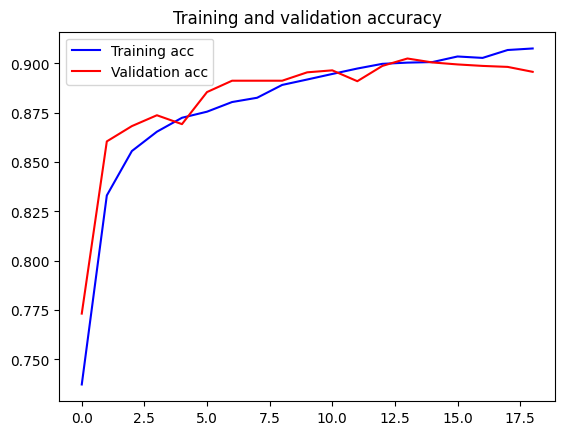

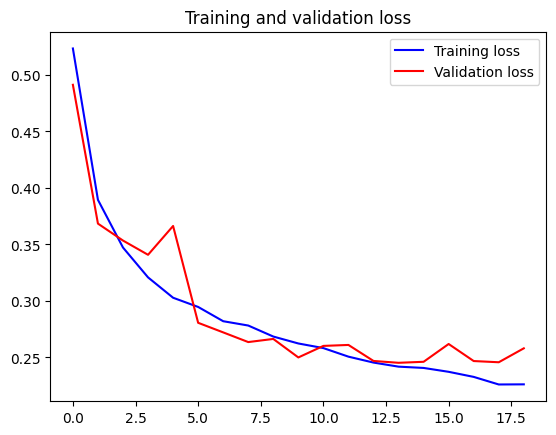

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [34]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = cbow_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [35]:
predict("I think this is a very great movie.")

1/1 [==============================] - 1s 605ms/step


{'label': 'positive',
 'score': 0.9579498767852783,
 'elapsed_time': 0.6600337028503418}

In [36]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = cbow_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 2s 335ms/step
CPU times: user 1.38 s, sys: 518 ms, total: 1.89 s
Wall time: 1.89 s


In [37]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

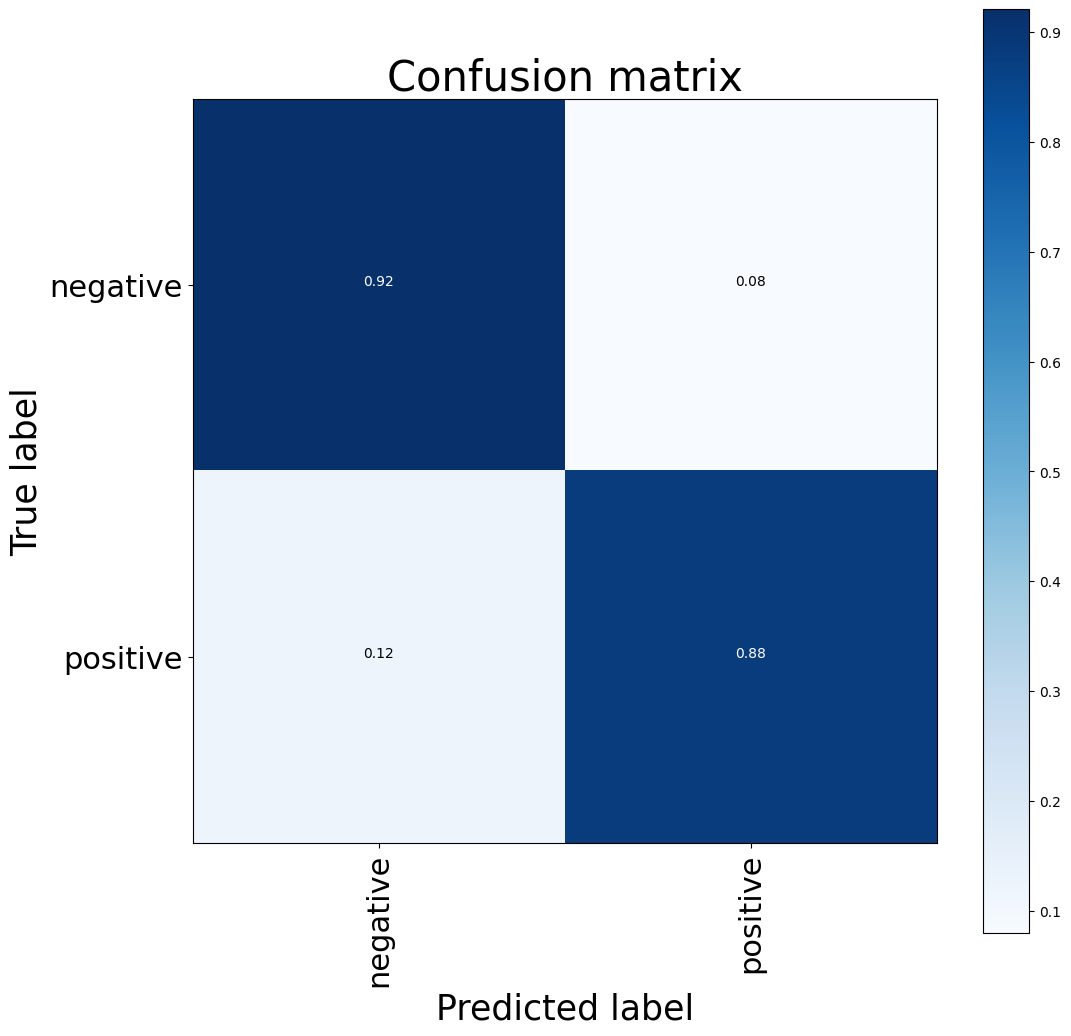

CPU times: user 415 ms, sys: 227 ms, total: 642 ms
Wall time: 412 ms


In [38]:
# Obtain the confusion matrix

%%time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

In [39]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.88      0.92      0.90      4961
    positive       0.92      0.88      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [40]:
# Obtain the accuracy score

accuracy_score(y_test_1d, y_pred_1d)

0.8995

In [43]:
# Save the tokenizer, word2vec, encoder and bilstm model

import pickle

KERAS_MODEL = "Sentiment_bilstm_w2vCBOW.sav"
WORD2VEC_MODEL = "modelCBOW.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizerCBOW.pkl"
ENCODER_MODEL = "encoderCBOW.pkl"

gdrive_path = '/content/drive/MyDrive/mydata/ModelFolder/'

cbow_model.save(f"{gdrive_path}{KERAS_MODEL}")
w2vmodel_cbow.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)